In [1]:
import logging
import os
import shutil
import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline
from sklearn.cluster import KMeans
from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/Users/ilyaasvesper/Documents/GitHub/time-series-forecasting-cluserting/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_embeddings(path, ticker):
    try:
        pipeline = BaseChronosPipeline.from_pretrained(
            "amazon/chronos-t5-tiny",
            device_map="auto",
            torch_dtype=torch.bfloat16,
        )
    except ImportError as e:
        logging.error(f"Error loading the Chronos model for {ticker}: {e}")
        raise ImportError(f"Error loading the Chronos model for {ticker}: {e}")

    try:
        df = pd.read_parquet(path)
        context = torch.tensor(df["Close"].values)
        embeddings, tokenizer_state = pipeline.embed(context)

        avg_embedding = embeddings[:, :-1, :].float().mean(dim=1)[0]
    except ValueError as e:
        logging.error(f"Error extracting embeddings for {ticker}: {e}")
        raise ValueError(f"Error extracting embeddings for {ticker}: {e}")
    
    logging.info(f"✅ Successfully extracted embeddings for {ticker}.")
    return avg_embedding, tokenizer_state


def extract_all_embeddings(data_dir):
    try:
        data_dir = Path(data_dir)
        files = list(data_dir.glob("*.parquet"))
    except FileExistsError as e:
        logging.error(f"❌ Directory {data_dir} not found, {e}.")
        raise FileExistsError(f"❌ Directory {data_dir} not found, {e}.")
    
    tickers = []
    embedding_list = []
    
    for file_path in files:
        ticker = file_path.stem
        embeddings, _ = get_embeddings(file_path, ticker)

        # If embeddings has a singleton batch dimension (e.g., shape (1, T, D)), squeeze it.
        if embeddings.ndim == 3 and embeddings.shape[0] == 1:
            embeddings = embeddings.squeeze(0)  # Now shape becomes (T, D)
        
        # # If embeddings are time-distributed (i.e. shape (T, D)), average over time axis.
        # if embeddings.ndim == 2:
        #     embedding_vector = embeddings.mean(dim=0).float().numpy()
        # else:
        #     embedding_vector = embeddings.float().numpy()

        tickers.append(ticker)
        embedding_list.append(embeddings)
    logging.info(f"✅ Successfully extracted all embeddings for time series in {data_dir}.")
    return tickers, np.array(embedding_list)


def cluster_embeddings(data_dir, n_clusters=5):
    tickers, embeddings_array = extract_all_embeddings(data_dir)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings_array)

    ticker_cluster_dict = {ticker: cluster for ticker, cluster in zip(tickers, clusters)}
    return ticker_cluster_dict


def save_stocks_to_cluster_dirs(clusters, data_directory, output_directory):
    try:
        cluster_dirs = {cluster: os.path.join(output_directory, f"cluster_{cluster}")
                        for cluster in set(clusters.values())}
        for path in cluster_dirs.values():
            os.makedirs(path, exist_ok=True)

        for stock, cluster in clusters.items():
            source_file = os.path.join(data_directory, f"{stock}.parquet")
            dest_file = os.path.join(cluster_dirs[cluster], f"{stock}.parquet")
            if os.path.exists(source_file):
                shutil.copy(source_file, dest_file)
                logging.info(f"Copied {stock}.parquet to cluster_{cluster} directory.")
            else:
                logging.warning(f"❌ File {source_file} not found!")
    except FileNotFoundError as e:
        logging.error(f"❌ Directory {data_directory} not found: {e}")


# if __name__ == "__main__":
#     data_directory = "/Users/ilyaasvesper/Documents/GitHub/time-series-forecasting-cluserting/data/chronos/"
#     output_directory = "/Users/ilyaasvesper/Documents/GitHub/time-series-forecasting-cluserting/clusters/embeddings/"
#     n_clusters = 5  # Adjust based on your analysis
#     clusters_dict = cluster_embeddings(data_directory, n_clusters)
#     save_stocks_to_cluster_dirs(clusters_dict, data_directory, output_directory)

In [3]:
data_directory = "/Users/ilyaasvesper/Documents/GitHub/time-series-forecasting-cluserting/data/chronos/"
tickers, embeddings_array = extract_all_embeddings(data_directory)

In [4]:
embeddings_array.shape 

(49, 256)

In [5]:
### saves UMAP and HDBSCAN models

import umap
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import pickle
import joblib
from collections import Counter

def umap_hdbscan_clustering2(
    eos_embeddings_array, 
    n_neighbors=30, 
    n_components=4, 
    min_dist=0.1, 
    umap_metric='cosine', 
    random_state=42, 
    hdbscan_min_cluster_size=80, 
    hdbscan_min_samples=80, 
    hdbscan_metric='euclidean',
    save_models=True, 
    save_path="umap_hdbscan_model"
):
    """
    Perform UMAP dimensionality reduction followed by HDBSCAN clustering and optionally save models.

    Parameters:
    - eos_embeddings_array (ndarray): The input embeddings to be reduced and clustered.
    - n_neighbors (int): Number of neighbors for UMAP.
    - n_components (int): Number of UMAP dimensions.
    - min_dist (float): Minimum distance for UMAP.
    - umap_metric (str): Distance metric for UMAP.
    - random_state (int): Random state for reproducibility.
    - hdbscan_min_cluster_size (int): Minimum size of clusters for HDBSCAN.
    - hdbscan_min_samples (int): Minimum number of samples for HDBSCAN.
    - hdbscan_metric (str): Distance metric for HDBSCAN.
    - save_models (bool): Whether to save the UMAP and HDBSCAN models.
    - save_path (str): File path prefix for saving models.

    Returns:
    - cluster_labels (ndarray): Cluster labels assigned by HDBSCAN.
    - reducer (UMAP): Trained UMAP reducer.
    - clusterer (HDBSCAN): Trained HDBSCAN clusterer.
    - embedding (ndarray): UMAP-reduced embeddings.
    """
    
    # Initialize and fit UMAP
    reducer = umap.UMAP(
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric=umap_metric, 
        random_state=random_state, 
        n_components=n_components
    )
    
    embedding = reducer.fit_transform(eos_embeddings_array)

    # Apply HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=hdbscan_min_cluster_size, 
        min_samples=hdbscan_min_samples, 
        metric=hdbscan_metric
    )
    
    cluster_labels = clusterer.fit_predict(embedding)

    # Save UMAP and HDBSCAN models if required
    if save_models:
        joblib.dump(reducer, f"{save_path}_umap.pkl")
        joblib.dump(clusterer, f"{save_path}_hdbscan.pkl")
        np.save(f"{save_path}_embedding.npy", embedding)
        print(f"Models saved to {save_path}_umap.pkl and {save_path}_hdbscan.pkl")

    # Plot the UMAP projection with clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(label='Cluster Label')
    plt.title(f"UMAP Projection with HDBSCAN Clusters (n_neighbors={n_neighbors}, size={hdbscan_min_cluster_size}, samples={hdbscan_min_samples})")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

    # Analyze clustering results
    unique_labels = np.unique(cluster_labels)
    n_clusters = len(unique_labels[unique_labels != -1])
    n_noise_points = np.sum(cluster_labels == -1)
    cluster_counts = Counter(cluster_labels[cluster_labels != -1])

    print(f"Number of clusters found: {n_clusters}")
    print(f"Number of noise points: {n_noise_points}")
    print("Cluster sizes:")
    for label, count in cluster_counts.items():
        print(f"Cluster {label}: {count} points")

    print("Cluster persistence:")
    print(clusterer.cluster_persistence_)
    
    noise_ratio = (sum(clusterer.labels_ == -1) / len(clusterer.labels_)) * 100
    print(f"Noise Percentage: {noise_ratio:.2f}%")

    return noise_ratio, cluster_labels, reducer, clusterer, embedding


Models saved to umap_hdbscan_model_umap.pkl and umap_hdbscan_model_hdbscan.pkl


/Users/ilyaasvesper/Documents/GitHub/time-series-forecasting-cluserting/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


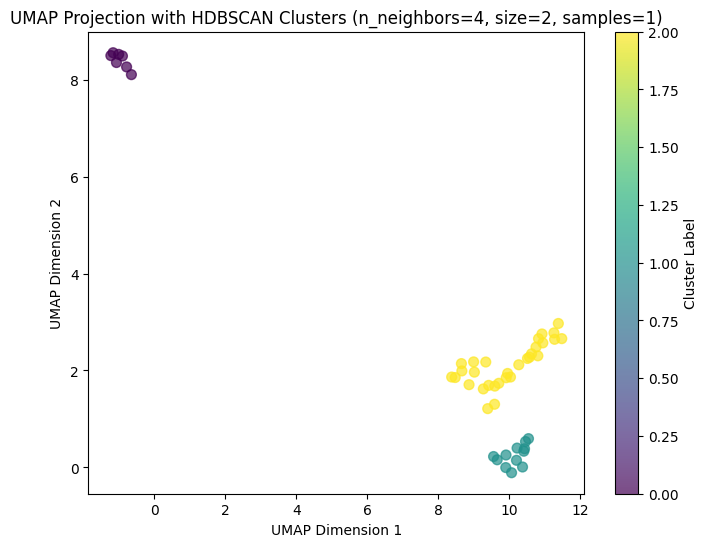

Number of clusters found: 3
Number of noise points: 0
Cluster sizes:
Cluster 2: 30 points
Cluster 1: 12 points
Cluster 0: 7 points
Cluster persistence:
[0.39788429 0.18182088 0.13018465]
Noise Percentage: 0.00%


In [15]:
noise_ratio, cluster_labels_filtered_ave2, reducer, clusterer, embedding = umap_hdbscan_clustering2(embeddings_array, n_neighbors=4, n_components=5, hdbscan_min_cluster_size=2, hdbscan_min_samples=1)

In [17]:
cluster_labels_filtered_ave2

array([2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2,
       2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 1, 0, 2])

In [34]:
cluster_index = np.where(cluster_labels_filtered_ave2 == 0)
indices = cluster_index[0]
selected_tickers = [tickers[i] for i in indices]
selected_tickers

['NKE', 'MRNA', 'PFE', 'F', 'PEP', 'JNJ', 'INTC']

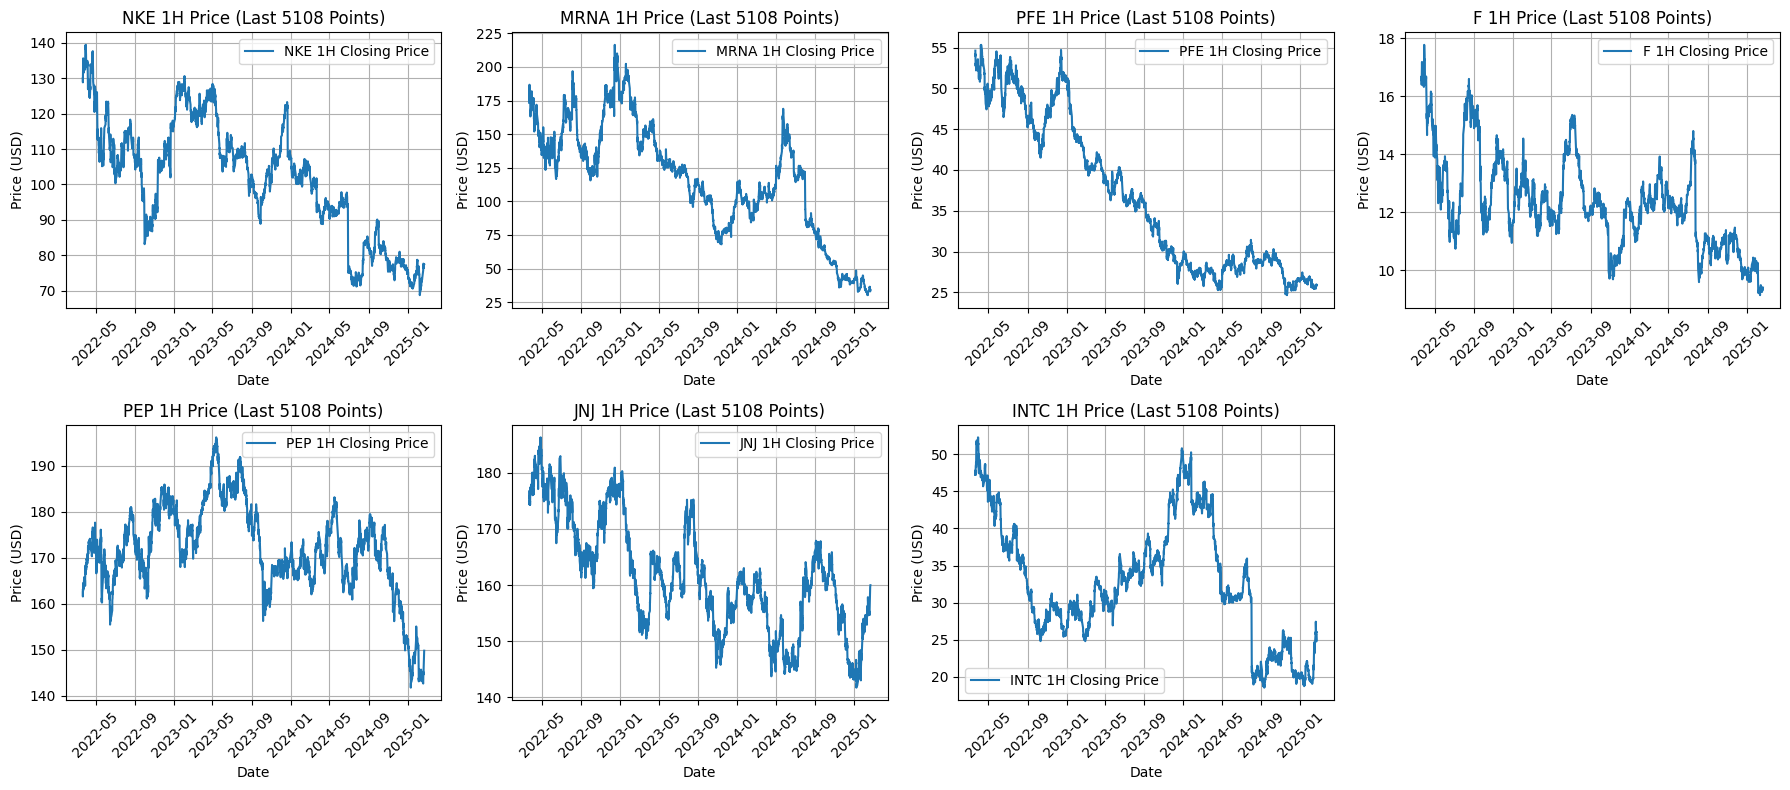

In [35]:
def plot_cluster_tickers_parquet(selected_tickers, data_dir="/Users/ilyaasvesper/Documents/GitHub/time-series-forecasting-cluserting/data/raw/", max_plots=8):
    """
    Plots up to `max_plots` tickers (default=8) in a 2x4 grid of subplots 
    from .parquet files stored in `data_dir`.

    :param selected_tickers: List of ticker symbols to plot.
    :param data_dir: Path to the directory containing <ticker>.parquet files.
    :param max_plots: Maximum number of ticker plots (subplots) to show.
    """
    # Create a 2x4 grid (8 total subplots)
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))
    axes = axes.flatten()  # Flatten to iterate easily

    # Plot each ticker (limit to `max_plots`)
    for i, ticker in enumerate(selected_tickers[:max_plots]):
        file_path = os.path.join(data_dir, f"{ticker}.parquet")
        
        if os.path.exists(file_path):
            # Read the .parquet file
            df = pd.read_parquet(file_path)
            
            # Plot "Close" price vs "Date"
            axes[i].plot(df["Date"], df["Close"], label=f"{ticker} 1H Closing Price")
            axes[i].set_title(f"{ticker} 1H Price (Last {df.shape[0]} Points)")
            axes[i].set_xlabel("Date")
            axes[i].set_ylabel("Price (USD)")
            axes[i].legend()
            axes[i].grid(True)
            # Rotate X-axis date labels for readability
            for tick_label in axes[i].get_xticklabels():
                tick_label.set_rotation(45)
        else:
            # If .parquet file not found, show a message
            axes[i].text(
                0.5, 0.5, 
                f"File not found:\n{ticker}.parquet",
                ha="center", va="center", 
                transform=axes[i].transAxes
            )
            axes[i].axis("off")
    
    # Turn off any unused subplots if fewer than 8 tickers
    for j in range(i+1, max_plots):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_cluster_tickers_parquet(selected_tickers, data_dir="/Users/ilyaasvesper/Documents/GitHub/time-series-forecasting-cluserting/data/raw/")
